<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Detect and Measure Sources in a Custom Coadded Image</b> <br>
Contact author: Melissa Graham <br>
Last verified to run: 2023-04-12 <br>
LSST Science Pipelines version: <b>Weekly 2022_40</b> <br>
Container Size: large <br>
Targeted learning level: advanced <br>

___

**WARNING:
This notebook will only run with LSST Science Pipelines version Weekly 2022_40.**

To find out which version of the LSST Science Pipelines you are using, look in the footer bar or execute the cell below.

In [1]:
! echo $IMAGE_DESCRIPTION

Weekly 2022_40


If you are using `w_2022_40`, you may proceed with executing the tutorial.

If you are **not** using `w_2022_40` you **must** log out and start a new server:
 1. At top left in the menu bar choose File then Save All and Exit.
 2. Re-enter the Notebook Aspect.
 3. At <a href="https://dp0-2.lsst.io/data-access-analysis-tools/nb-intro.html#how-to-log-in-navigate-and-log-out-of-jupyterlab">the "Server Options" stage</a>, under "Select uncached image (slower start)" choose `w_2022_40`.
 4. Note that it might take a few minutes to start your server with an old image.

___

<br><br><br><br>

**Description:** Detect and measure sources in a custom "deepCoadd" image.

**Skills:** Use the butler on user-generated collections. Run source detection and measurement.

**LSST Data Products:** user-generated deepCoadd; DP0.2 deepCoadd image and Object table

**Packages:** lsst.afw, lsst.pipe, lsst.meas

**Credit:** Originally developed by Melissa Graham and Clare Saunders, this tutorial draws on the contents of the "Introduction to Source Detection" DP0.2 tutorial notebook by Douglas Tucker and Alex Drlica-Wagner.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.


> **WARNING: This tutorial uses the output of notebook 09a_Custom_Coadd.ipynb. Users must run that notebook first.**


# 1. Introduction

This tutorial notebook is a follow-up to 09a_Custom_Coadd.ipynb, and demonstrates how to run source detection and measurement on a user-generated custom `deepCoadd` image.

Recall that although that new custom `deepCoadd` is not actually deep, but a rather shallower custom coadd, it will still be called `deepCoadd` in the butler because that is the default name of results from the `assembleCoadd` task.

**This tutorial notebook may evolve in the near future.**
In tutorial notebook 09a_Custom_Coadd.ipynb, we use the Simple Pipeline Executor (SPE) to build a pipeline that runs components of the Data Release Pipeline (DRP).
In _this_ tutorial notebook, instead of building a pipeline to run the DRP components for detection, deblending, and measurement, and then writing a table with the same schema as the `Object` table, we are simply executing the standalone tasks for source detection and measurement. This is faster and simpler, but in the future this notebook will be updated to use the SPE.

## 1.1. Package imports

In [2]:
import time, getpass
import numpy as np
import pandas
import matplotlib.pyplot as plt
from astropy.wcs import WCS

import lsst.geom
from lsst.daf.butler import Butler, CollectionType
from lsst.rsp import get_tap_service, retrieve_query
import lsst.daf.base as dafBase
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

## 1.2. Define functions and parameters

Set `afwDisplay` to use a `matplotlib` backend.

In [3]:
afwDisplay.setDefaultBackend('matplotlib')

Instantiate the TAP service, which is used in Section 3.3.

In [4]:
tap_service = get_tap_service()

## 1.3. Find the desired coadd in the butler

Create a temporary butler in order to identify the collection and run containing the custom `deepCoadd`.

In [5]:
my_username = getpass.getuser()
collection = "u/"+my_username

In [6]:
tempButler = Butler('dp02')

Print all collections and runs associated with your username.

In [7]:
for c in sorted(tempButler.registry.queryCollections('*'+my_username+'*')):
    print(c)

u/ameisner/custom_coadd_window1_cl00
u/ameisner/custom_coadd_window1_cl00/20230502T052541Z
u/ameisner/custom_coadd_window1_cl00/20230514T103114Z
u/ameisner/custom_coadd_window1_cl00/20230514T121205Z
u/ameisner/custom_coadd_window1_cl00/20230514T212053Z
u/ameisner/custom_coadd_window1_cl00/20230603T001742Z
u/ameisner/custom_coadd_window1_cl00/20230817T123603Z
u/ameisner/custom_coadd_window1_cl00/20230826T102521Z
u/ameisner/custom_coadd_window1_cl00/20230827T122706Z
u/ameisner/custom_coadd_window1_cl00/20230827T224022Z
u/ameisner/custom_coadd_window1_cl00/20230918T050251Z
u/ameisner/custom_coadd_window1_cl00/20230918T050641Z
u/ameisner/custom_coadd_window1_cl00/20230918T052104Z
u/ameisner/custom_coadd_window1_cl00/20230918T052710Z
u/ameisner/custom_coadd_window1_cl00/20230918T054822Z
u/ameisner/custom_coadd_window1_cl00/20230927T225000Z
u/ameisner/custom_coadd_window1_test1
u/ameisner/custom_coadd_window1_test1/20230425T101643Z
u/ameisner/custom_coadd_window1_test1/20230427T092803Z
u/ame

Delete this temporary butler.

In [8]:
del tempButler

Create a new butler with the collection containing the custom `deepCoadd`.

> **Stop!** Make sure the name of the collection below matches the name of your own collection that you created with tutorial notebook 09a_Custom_Coadd.ipynb.

In [9]:
collection = "u/"+my_username+"/custom_coadd_window1_test999"
print(collection)

u/ameisner/custom_coadd_window1_test999


In [10]:
butler = Butler('dp02', collections=[collection])

Use the `dataId` from tutorial notebook 09a_Custom_Coadd.ipynb and retrieve the custom `deepCoadd`.

In [11]:
my_dataId = {'band': 'i', 'tract': 4431, 'patch': 17}
my_deepCoadd = butler.get('deepCoadd', my_dataId)

Confirm that the retrieved `deepCoadd` is the custom user-generated 6-input visits version.

In [12]:
my_deepCoadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()
my_deepCoadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
919515,11900,7900,16099,12099,8982709,3.4656688819793495,i_sim_1.4
924057,11900,7900,16099,12099,16098179,4.384267091685517,i_sim_1.4
924085,11900,7900,16099,12099,831332,4.446833161599578,i_sim_1.4
924086,11900,7900,16099,12099,16136708,4.550420295334223,i_sim_1.4
929477,11900,7900,16099,12099,16280498,4.051326013718346,i_sim_1.4
930353,11900,7900,16099,12099,16076133,3.7685753871220466,i_sim_1.4


# 2. Run source detection and measurement

## 2.1. Create schema

Create a basic schema to use with the source measurement and detection tasks.

In [13]:
schema = afwTable.SourceTable.makeMinimalSchema()
print(schema)

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)



Create a container, `algMetadata`, which will be used to record metadata about algorithm execution.

In [14]:
algMetadata = dafBase.PropertyList()
print('algMetadata: ')
algMetadata

algMetadata: 


## 2.2. Configure tasks

Configure the task to characterize the image. 
Use just one iteration to determine the point spread function (PSF).

In [15]:
"""
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)
"""

'\nconfig = CharacterizeImageTask.ConfigClass()\nconfig.psfIterations = 1\ncharImageTask = CharacterizeImageTask(config=config)\n'

Configure the task to detect sources.
Set the threshold that defines what "detected" means to be 10 times above the standard deviation (i.e., a signal-to-noise ratio of 10).

In [16]:
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

No special configurations are used for the deblender in this example.

In [17]:
sourceDeblendTask = SourceDeblendTask(schema=schema)

No special configurations are used for the source measurements.

In [18]:
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                   algMetadata=algMetadata)

**Option:** the help documentation can be accessed with the `help()` command.

In [19]:
# help(sourceMeasurementTask.ConfigClass())

## 2.3. Characterize image

Send the standard output (a structure) into `result_ci` to avoid having it display to screen (see Section 2.4 for more about structures).

The following cell will still provide standard output information about progress of the task.

In [20]:
"""
result_ci = charImageTask.run(my_deepCoadd)
"""

'\nresult_ci = charImageTask.run(my_deepCoadd)\n'

One of the steps of image characterization is to compute the PSF size.

**Option:** print the PSF's Full-Width Half-Max (FWHM) size at the center of the image.

In [21]:
# bbox = my_deepCoadd.getBBox()
# center = lsst.geom.Point2D(bbox.centerX, bbox.centerY)
# psf = my_deepCoadd.getPsf()
# sigma = psf.computeShape(center).getDeterminantRadius()
# scale = my_deepCoadd.wcs.getPixelScale().asArcseconds()
# print('PSF FWHM = {:.2f} arcsec'.format(sigma * scale * 2.355))
# del bbox, center, psf, sigma, scale

## 2.4. Detect sources

Create a source table for holding the output.

In [22]:
srctab = afwTable.SourceTable.make(schema)

Run the source detection task.
Send the standard output (a structure) into `result_sd`. 
A few lines of information about the task's progress will still display to the screen.

In [23]:
result_sd = sourceDetectionTask.run(srctab, my_deepCoadd)

The result returned is a `Struct`, a generalized container. Investigate with `getDict`.

In [24]:
for k, v in result_sd.getDict().items():
    print(k, type(v))

positive <class 'lsst.afw.detection.FootprintSet'>
negative <class 'NoneType'>
factor <class 'float'>
positiveThreshold <class 'lsst.afw.detection.Threshold'>
negativeThreshold <class 'lsst.afw.detection.Threshold'>
background <class 'lsst.afw.math._backgroundList.BackgroundList'>
numPos <class 'int'>
numPosPeaks <class 'int'>
numNeg <class 'int'>
numNegPeaks <class 'int'>
fpSets <class 'lsst.pipe.base.struct.Struct'>
sources <class 'lsst.afw.table.SourceCatalog'>


Print how many positive peaks were found.

In [25]:
result_sd.numPosPeaks

2517

Store the detected sources in a new table called `sources`.

In [26]:
sources = result_sd.sources

> **Notice:** The data in the sources table will be mostly NaN before deblending and measurement are done.

**Option:** display the mostly-empty sources table.

In [27]:
# sources

## 2.5. Deblend sources

This task does not create a structure, but rather modifies the passed `sources` table in-place, so we do not need to use `results = ` in this case.

In [28]:
sourceDeblendTask.run(my_deepCoadd, sources)

## 2.6. Measure sources

This task does not create a structure, but also modifies the `sources` table in-place, so we do not need to use `results = ` for this step either.

In [29]:
sourceMeasurementTask.run(measCat=sources, exposure=my_deepCoadd)

# 3. Analyze sources

## 3.1. Explore the source table contents

Make the results into an astropy table for better human interaction.

First, make a copy.
Otherwise, the second cell below will fail with the error message _"Record data is not contiguous in memory."_

In [30]:
sources = sources.copy(True)

In [31]:
my_sources = sources.asAstropy()

**Option:** print all of the column names of source measurements.

In [32]:
# my_sources.colnames

**Option:** explore which columns are flux measurements (not flux flags!) and which have been populated with nonzero flux values.

In [33]:
# for col in my_sources.colnames:
#     if ((col.find('Flux') >= 0) | (col.find('flux') >= 0)) & (col.find('flag') < 0):
#         tx = np.where(my_sources[col] > 0.0)[0]
#         print(len(tx), col)
#         del tx

Convert `instFlux` to AB apparent magnitudes.

In [34]:
my_sources.add_column('i_CalibMag_AB')
my_sources['i_CalibMag_AB'] = np.zeros(len(my_sources), dtype='float')
my_deepCoadd_photoCalib = my_deepCoadd.getPhotoCalib()
for s in range(len(my_sources)):
    my_sources['i_CalibMag_AB'][s] = \
    my_deepCoadd_photoCalib.instFluxToMagnitude(my_sources['slot_CalibFlux_instFlux'][s])

Plot the apparent i-band magnitude distribution of detected sources.

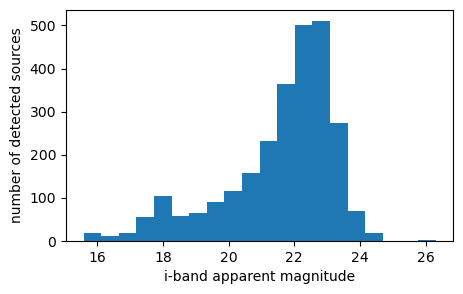

In [35]:
plt.figure(figsize=(5, 3))
plt.hist(my_sources['i_CalibMag_AB'], bins=20)
plt.xlabel('i-band apparent magnitude')
plt.ylabel('number of detected sources')
plt.show()

## 3.2. Plot detected sources on a cutout of the custom coadd

Create a 1000 by 1000 pixel cutout of the custom `deepCoadd`.

In [36]:
cutout_width = 1000
cutout_height = 1000
my_cutout_bbox = lsst.geom.Box2I(lsst.geom.Point2I(my_deepCoadd.getX0(),
                                                   my_deepCoadd.getY0()),
                                 lsst.geom.Extent2I(cutout_width, cutout_height))
my_cutout = my_deepCoadd.Factory(my_deepCoadd, my_cutout_bbox)

Print the center coordinates of the cutout.

In [37]:
bbox = my_cutout.getBBox()
wcs = my_cutout.wcs
fitsMd = wcs.getFitsMetadata()
WCSfMd = WCS(fitsMd)
center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
print('Cutout center (RA, Dec): ', center)

Cutout center (RA, Dec):  (55.7572944294, -32.2945077996)


Recall from tutorial notebook 09a that the 'science use case' adopted for context was that there was a (hypothetical) supernova at RA = 55.745834, Dec = -32.269167, and we were looking for evidence of a precursor outburst during Window1.

Convert those coordinates into a pixel location.

In [38]:
sn_coords = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees, -32.269167*lsst.geom.degrees)
sn_pix = wcs.skyToPixel(sn_coords)
print(sn_pix)

(12573, 8855.8)


Display cutout with detected sources as orange circles, and the supernova location as a larger green circle.

<Figure size 640x480 with 0 Axes>

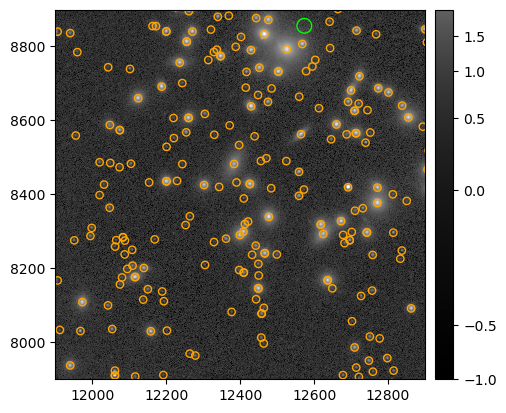

In [39]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_cutout.image)

afw_display.dot('o', sn_pix[0], sn_pix[1], size=20, ctype='green')

with afw_display.Buffering():
    for s in sources:
        afw_display.dot('o', s.getX(), s.getY(), size=10, ctype='orange')

Above, we can see that there is no source detected at 10-sigma (defined by `config.thresholdValue` above in Section 2.2) at the location of the (hypothetical) supernova (green circle). 

In Section 4, an exercise for the learner is to re-run source detection with a lower sigma, which would be the next analysis step for the science use-case of exploring precursor eruptions.
Recall that the DC2 simulation did not include precursor eruptions for supernovae, though -- and that there is no actual simulated supernova at the coordinates anyway. 
They are just used as an example.

In [40]:
del bbox, wcs, fitsMd, WCSfMd, center

## 3.3. Compare with Objects in the original deepCoadd image

### 3.3.1. Make a cutout of the original deepCoadd

Instantiate a temporary butler that looks only at the DP0.2 collection.

In [41]:
tempButler = Butler('dp02', collections='2.2i/runs/DP0.2')

Use the same `dataId` that defines the custom `deepCoadd`.
Since we are using a temporary butler that only looks at the DP0.2 data release collection, and not the user collection, this will retrieve the original `deepCoadd`, not the custom `deepCoadd`.

In [42]:
deepCoadd = tempButler.get('deepCoadd', my_dataId)

Double check that this `deepCoadd` is the result of 161 input visits.

In [43]:
deepCoadd_inputs = tempButler.get("deepCoadd.coaddInputs", my_dataId)
len(deepCoadd_inputs.visits.asAstropy())

161

In [44]:
del tempButler

Create a cutout from the original `deepCoadd`.

In [45]:
cutout_bbox = lsst.geom.Box2I(lsst.geom.Point2I(deepCoadd.getX0(),
                                                deepCoadd.getY0()),
                              lsst.geom.Extent2I(cutout_width, cutout_height))
cutout = deepCoadd.Factory(deepCoadd, cutout_bbox)

**Option:** display the original `deepCoadd` cutout.

In [46]:
# plt.figure()
# afw_display = afwDisplay.Display()
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(cutout.image)

### 3.3.2. Retrieve Objects via TAP

Use the TAP service to query and return the i-band calibrated fluxes for `Objects` detected with a signal-to-noise ratio > 10 (to match the custom coadd detection threshold set in Section 2.2) in the original `deepCoadd`, within the cutout area.

Recall that the cutout center coordinates are: 55.7572944294, -32.2945077996. Use these as the central coordinates for the TAP query.

In [47]:
%%time
query = "SELECT objectId, coord_ra, coord_dec, detect_isPrimary, " + \
        "scisql_nanojanskyToAbMag(i_calibFlux) AS i_calibMag, " + \
        "scisql_nanojanskyToAbMagSigma(i_calibFlux, i_calibFluxErr) AS i_calibMagErr, " + \
        "i_extendedness " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', 55.757, -32.295, 0.2)) = 1 " + \
        "AND i_calibFlux/i_calibFluxErr >= 10 " + \
        "AND detect_isPrimary = 1"
tap_results = tap_service.search(query)

CPU times: user 372 ms, sys: 18.8 ms, total: 391 ms
Wall time: 4.98 s


Store the TAP results in a pandas table.

In [48]:
tap_table = tap_results.to_table().to_pandas()

Convert `Object` sky coordinates (RA, Dec) to `deepCoadd` pixels (x,y) and store in the TAP results table.

In [49]:
wcs = cutout.wcs
temp1 = np.zeros(len(tap_table), dtype='float')
temp2 = np.zeros(len(tap_table), dtype='float')

for i in range(len(tap_table['coord_ra'].values)):
    sP = lsst.geom.SpherePoint(tap_table['coord_ra'][i]*lsst.geom.degrees, \
                               tap_table['coord_dec'][i]*lsst.geom.degrees)
    cpix = wcs.skyToPixel(sP)
    temp1[i] = float(cpix[0])
    temp2[i] = float(cpix[1])
    del sP, cpix

tap_table['cutout_x'] = temp1
tap_table['cutout_y'] = temp2

del wcs, temp1, temp2

### 3.3.3. Plot images side-by-side

Plot the new custom `deepCoadd` (left; 6 input visits) and original `deepCoadd` (right; 161 input visits) cutouts side-by-side.

Show newly detected sources in the custom `deepCoadd` (orange) and `Object` catalog sources from the original `deepCoadd` (red).

Making these side-by-side images can take a minute.

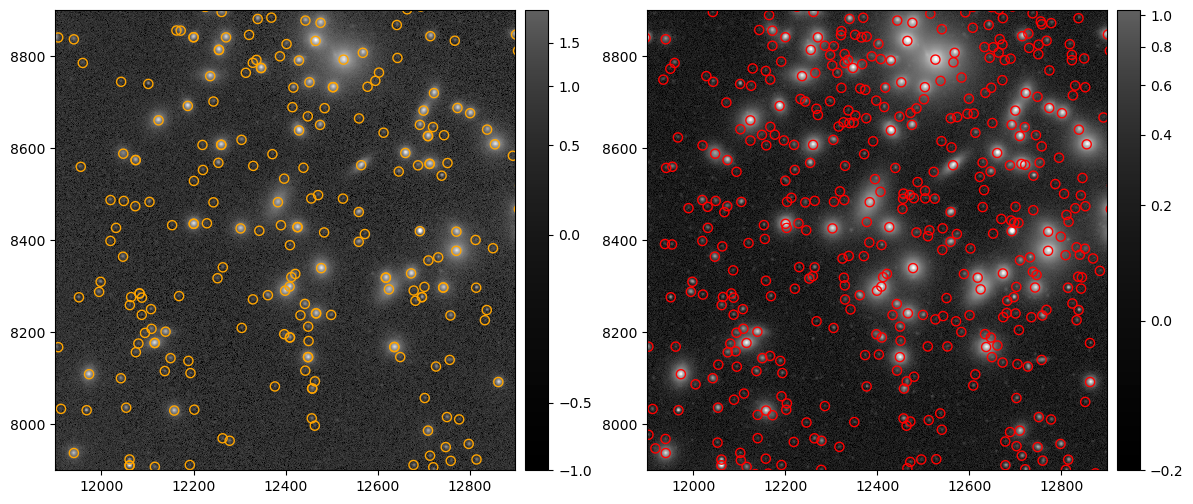

CPU times: user 18.6 s, sys: 304 ms, total: 18.9 s
Wall time: 18.7 s


In [50]:
%%time

fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=False, sharex=False)

plt.subplot(1, 2, 1)
disp1 = afwDisplay.getDisplay(frame=fig)
disp1.scale('asinh', 'zscale')
disp1.mtv(my_cutout.image)

with disp1.Buffering():
    for s in sources:
        disp1.dot('o', s.getX(), s.getY(), size=10, ctype='orange')

plt.subplot(1, 2, 2)
disp2 = afwDisplay.getDisplay(frame=fig)
disp2.scale('asinh', 'zscale')
disp2.mtv(cutout.image)

with disp2.Buffering():
    for s in range(len(tap_table)):
        disp2.dot('o', tap_table['cutout_x'][s], tap_table['cutout_y'][s], size=10, ctype='red')

plt.show()

### 3.3.4. Compare apparent magnitudes

For sources detected in both the custom `deepCoadd` _and_ the original `deepCoadd`, plot a comparison of their apparent i-band magnitudes.

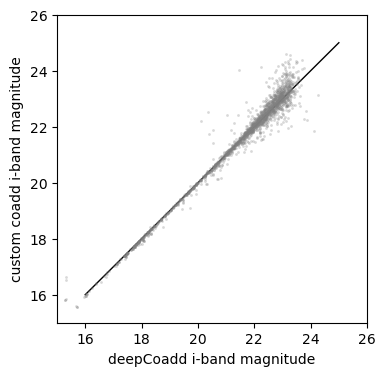

In [51]:
plt.figure(figsize=(4, 4))

plt.plot([16, 25], [16, 25], lw=1, ls='solid', color='black')

for s in range(len(my_sources)):
    tx = np.where((np.abs(my_sources['base_SdssCentroid_x'][s] - tap_table['cutout_x'][:]) < 5.0)
                  & (np.abs(my_sources['base_SdssCentroid_y'][s] - tap_table['cutout_y'][:]) < 5.0))[0]
    if len(tx) == 1:
        plt.plot(tap_table['i_calibMag'][tx[0]],
                 my_sources['i_CalibMag_AB'][s],
                 'o', ms=2, alpha=0.3, mew=0, color='grey')

plt.xlim([15, 26])
plt.ylim([15, 26])
plt.xlabel('deepCoadd i-band magnitude')
plt.ylabel('custom coadd i-band magnitude')
plt.show()

The above is only for _matched sources_.

Below, compare the apparent magnitude distributions for everything detected in the two images.

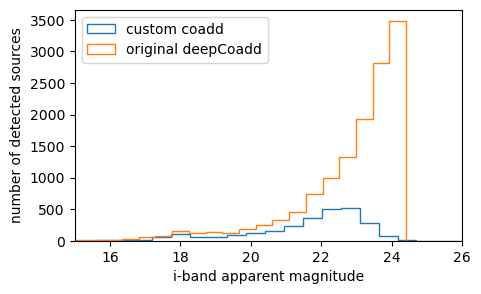

In [52]:
plt.figure(figsize=(5, 3))

plt.hist(my_sources['i_CalibMag_AB'], bins=20, histtype='step', label='custom coadd')
plt.hist(tap_table['i_calibMag'], bins=20, histtype='step', label='original deepCoadd')

plt.xlabel('i-band apparent magnitude')
plt.ylabel('number of detected sources')
plt.legend(loc='upper left')
plt.xlim([15, 26])
plt.show()

# 4. Exercises for the learner

1. Lower the source detection threshold (e.g., from 10 to 5) and rerun the source detection and analysis. Remember to change the SNR limit in the TAP query to the `Objects` table, in order to make a meaningful comparison. 
> (Recall that the `Objects` table only includes SNR>5 detections, so if the source detection threshold for the custom `deepCoadd` is lowered to below 5, a meaningful comparison with the `Objects` table will not be possible. Rerun source detection on the original `deepCoadd` if you want to explore low-SNR detections).
2. Compare not just the apparent magnitudes between the custom `deepCoadd` and original `deepCoadd`, but also shape parameters like PSF or the `SdssShape` moments.
3. Return to tutorial notebook 09a, create a custom `deepCoadd` for Window2, and compare it to the custom `deepCoadd` for Window1.